<a href="https://colab.research.google.com/github/taylor33189-beep/Taylor_Hoskins_Repository/blob/main/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


--- Simulation-Based (Bootstrap) Calculations ---
   Wins  Point Estimate  CI Lower (Bootstrap)  CI Upper (Bootstrap)  \
0    81        30223.98              27902.72              32503.70   
1   100        37974.99              32787.18              43199.65   

   PI Lower (Bootstrap)  PI Upper (Bootstrap)  
0              15372.02              41767.83  
1              23470.09              50750.19  


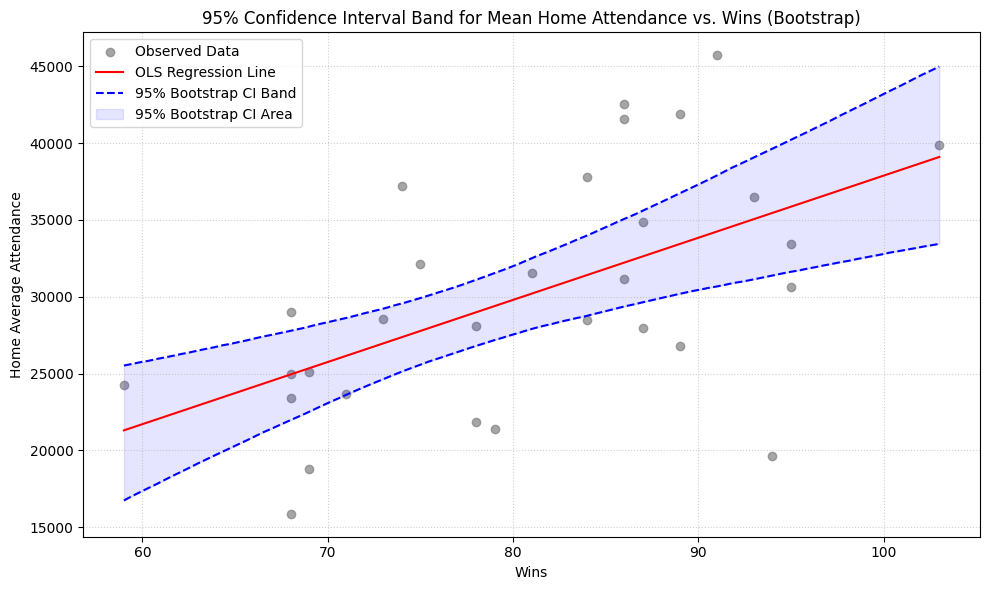

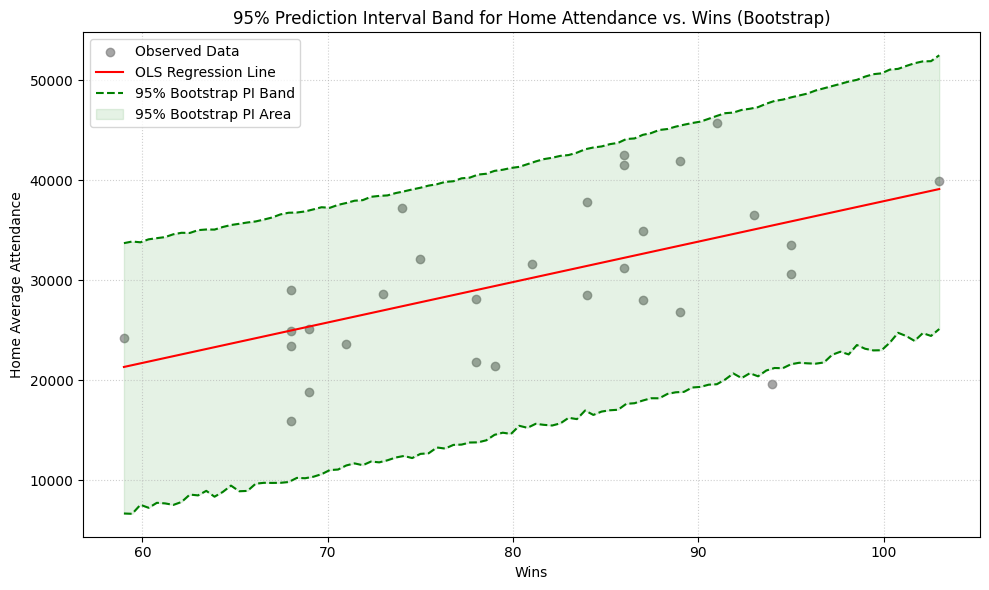

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = pd.read_csv('/content/attendance-2016.csv')

# Extract 'Wins' as the independent variable (x) and 'HomeAvgAtt' as the dependent variable (y)
x = df['Won'].values
y = df['HomeAvgAtt'].values
n = len(df)

# Add a constant (intercept term) to the independent variable for OLS regression
X = sm.add_constant(x)

# Fit the original Ordinary Least Squares (OLS) regression model
original_model = sm.OLS(y, X).fit()

# Calculate residuals from the original model (actual y - predicted y)
original_residuals = original_model.resid

centered_residuals = original_residuals - original_residuals.mean()

# --- Bootstrap Parameters and Initialization ---
B = 10000
x0_values = np.array([81, 100])

# Initialize arrays to store bootstrapped results for the two x0_values:
# y_hat_boot will store estimated mean responses (for Confidence Intervals)
# y_pred_boot will store predicted new observations (for Prediction Intervals)
y_hat_boot = np.zeros((B, len(x0_values)))
y_pred_boot = np.zeros((B, len(x0_values)))

# Define a range of x values (Wins) for plotting the confidence and prediction bands
x_range = np.linspace(x.min(), x.max(), 100)

# Initialize arrays to store bootstrapped regression lines for band plots:
# y_hat_boot_band for mean response
# y_pred_boot_band for new observations
y_hat_boot_band = np.zeros((B, len(x_range)))
y_pred_boot_band = np.zeros((B, len(x_range)))

# --- Bootstrap Loop ---
# This loop performs the bootstrap resampling and model fitting B times
for i in range(B):
    # 1. Resample with replacement: Randomly select 'n' indices from the original data
    sample_indices = np.random.choice(n, size=n, replace=True)

    # Create bootstrap samples for x and y using the resampled indices
    x_boot = x[sample_indices]
    y_boot = y[sample_indices]

    # Add a constant term to the bootstrapped x values for the OLS model
    X_boot = sm.add_constant(x_boot)

    # 2. Fit an OLS model to the bootstrap sample
    boot_model = sm.OLS(y_boot, X_boot).fit()

    # Extract the intercept (b0) and slope (b1) from the bootstrapped model
    b0_star = boot_model.params[0] # Intercept
    b1_star = boot_model.params[1] # Slope

    # 3. Calculate Point-wise Confidence Interval (CI) for E[Y|x0]
    # Estimate the mean response (y_hat) for the specific x0_values using the bootstrapped coefficients
    y_hat_star = b0_star + b1_star * x0_values
    y_hat_boot[i, :] = y_hat_star

    # 4. Calculate Point-wise Prediction Interval (PI) for a new observation Y_new|x0
    residual_star = np.random.choice(centered_residuals, size=len(x0_values), replace=True)

    y_pred_star = y_hat_star + residual_star
    y_pred_boot[i, :] = y_pred_star

    # 5. Calculate CI Band for E[Y|x] across the entire x_range
    # Estimate the mean response across the x_range using the bootstrapped coefficients
    y_hat_band_star = b0_star + b1_star * x_range
    y_hat_boot_band[i, :] = y_hat_band_star

    # 6. Calculate PI Band for Y_new|x across the entire x_range
    # Sample residuals for each point in x_range for the prediction band
    residual_band_star = np.random.choice(centered_residuals, size=len(x_range), replace=True)

    # The prediction for new observations across the band is the mean estimate plus sampled residuals
    y_pred_band_star = y_hat_band_star + residual_band_star
    y_pred_boot_band[i, :] = y_pred_band_star

# --- Point Estimates and Intervals (for x0=81, x0=100) ---
bootstrap_results = []
for idx, x0 in enumerate(x0_values):
    # Calculate the 95% Confidence Interval (CI) for the mean response
    # This is done by taking the 2.5th and 97.5th percentiles of the bootstrapped y_hat values
    ci_lower = np.percentile(y_hat_boot[:, idx], 2.5)
    ci_upper = np.percentile(y_hat_boot[:, idx], 97.5)

    # Calculate the 95% Prediction Interval (PI) for a new observation
    pi_lower = np.percentile(y_pred_boot[:, idx], 2.5)
    pi_upper = np.percentile(y_pred_boot[:, idx], 97.5)

    # Calculate the point estimate (average of all bootstrapped mean estimates)
    point_estimate = np.mean(y_hat_boot[:, idx])

    # Store the results for each x0 value
    bootstrap_results.append({
        'Wins': x0,
        'Point Estimate': point_estimate,
        'CI Lower (Bootstrap)': ci_lower,
        'CI Upper (Bootstrap)': ci_upper,
        'PI Lower (Bootstrap)': pi_lower,
        'PI Upper (Bootstrap)': pi_upper
    })

bootstrap_df = pd.DataFrame(bootstrap_results)
print("\n--- Simulation-Based (Bootstrap) Calculations ---")
print(bootstrap_df[['Wins', 'Point Estimate', 'CI Lower (Bootstrap)', 'CI Upper (Bootstrap)', 'PI Lower (Bootstrap)', 'PI Upper (Bootstrap)']].round(2))

bootstrap_df.to_csv('bootstrap_intervals.csv', index=False)

# --- Confidence Interval Band Plot ---
ci_lower_band = np.percentile(y_hat_boot_band, 2.5, axis=0)
ci_upper_band = np.percentile(y_hat_boot_band, 97.5, axis=0)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Observed Data', color='gray', alpha=0.7)
plt.plot(x_range, original_model.predict(sm.add_constant(x_range)), color='red', linestyle='-', label='OLS Regression Line')
plt.plot(x_range, ci_lower_band, color='blue', linestyle='--', label='95% Bootstrap CI Band')
plt.plot(x_range, ci_upper_band, color='blue', linestyle='--')
plt.fill_between(x_range, ci_lower_band, ci_upper_band, color='blue', alpha=0.1, label='95% Bootstrap CI Area')
plt.title('95% Confidence Interval Band for Mean Home Attendance vs. Wins (Bootstrap)')
plt.xlabel('Wins')
plt.ylabel('Home Average Attendance')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('confidence_interval_band.png')

# --- Prediction Interval Band Plot ---
# Calculate the 95% PI bands across the entire x_range
pi_lower_band = np.percentile(y_pred_boot_band, 2.5, axis=0)
pi_upper_band = np.percentile(y_pred_boot_band, 97.5, axis=0)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Observed Data', color='gray', alpha=0.7)
plt.plot(x_range, original_model.predict(sm.add_constant(x_range)), color='red', linestyle='-', label='OLS Regression Line')
plt.plot(x_range, pi_lower_band, color='green', linestyle='--', label='95% Bootstrap PI Band')
plt.plot(x_range, pi_upper_band, color='green', linestyle='--')
plt.fill_between(x_range, pi_lower_band, pi_upper_band, color='green', alpha=0.1, label='95% Bootstrap PI Area')
plt.title('95% Prediction Interval Band for Home Attendance vs. Wins (Bootstrap)')
plt.xlabel('Wins')
plt.ylabel('Home Average Attendance')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('prediction_interval_band.png')